In [2]:
import pandas as pd
import numpy as np
import cPickle as pickle
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline

### Function to plot Confusion Matrix

In [3]:
from matplotlib import pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
# Read data
with open('df_amenities_neighbourhood_all_processed.pkl', 'rb') as f:
    df = pickle.load(f)

### Prepare Target Variable Y = price

<code>Based on the clustering analysis, we identified that there would be two possible categories of listings:
Cheap and Expensive
Here, we use a 1-d KMeans clustering to obtain 2 clusters of records. The one with the higher cluster mean corresponds to expensive listings and the lower cluster mean for the cheaper listings. 
We use these cluster labels as class labels in our binary classification problem.

In [5]:
from sklearn.cluster import KMeans
cluster_model = KMeans(n_clusters=2, init='k-means++', random_state=13)
cluster_model.fit(df['price'].values.reshape(-1,1))
df['price'] = cluster_model.labels_

In [6]:
print "Cluster center (price) of cheap listings:", cluster_model.cluster_centers_[0]
print "Cluster center (price) of expensive listings:", cluster_model.cluster_centers_[1]
print "Data Split\n", df['price'].value_counts() # 0 = Cheap, 1 = Expensive

Cluster center (price) of cheap listings: [ 69.74718915]
Cluster center (price) of expensive listings: [ 161.84453518]
Data Split
0    6048
1    3184
Name: price, dtype: int64


### Preprocessing the Features

In [7]:
# Keep only the columns required for classification
cols = ['price', 'minimum_nights', 'number_of_reviews', 'instant_bookable', 'cancellation_policy', 
        'calculated_host_listings_count', 'num_page_saved',
        u'property_type','room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
        'Elevator in building', 'Internet', 'Family/kid friendly', 
        'Wireless Internet', 'Buzzer/wireless intercom', 'Kitchen', 'Doorman', 'Wheelchair accessible',
        'Cable TV', 'Hot tub', 'Gym', 'Pool', 'TV', 'Dryer', 'Washer', 'Essentials', 'Shampoo', 'Heating',
        'Air conditioning', 'Pets allowed', 'Suitable for events','Smoking allowed', 'Indoor fireplace', 
        'Breakfast', 'Laptop friendly workspace', 'Iron', 'Hangers', 'Hair dryer', 'Private living room',
        'Private entrance', 'Parking',
        'restaurant', 'atm', 'cinema', 'hospital', 'nightclub', 'park', 'mall', 'gallery', 'museum',
        'supermarket', 'bus_stop']
df = df.ix[:, cols]
print df.shape

(9232, 56)


In [8]:
# For the distance of neighbourhood facilities from the house, a value of '-1' was assigned 
# if the facility was absent in the specified threshold radius
# replace this -1 with a high distance value 
# A value of 1.5 times the original threshold radius
neighbourhood = {
    'restaurant': 1.5*2000,
    'atm': 1.5*5000,
    'cinema':1.5*15000,
    'hospital':1.5*15000,
    'nightclub':1.5*10000,
    'park':1.5*10000,
    'mall':1.5*10000,
    'museum':1.5*10000,
    'gallery':1.5*10000,
    'supermarket':1.5*5000,
    'bus_stop':1.5*1000
    }

for facility in neighbourhood.keys():
    for i in range(len(df[facility])):
        dist = df.ix[i,facility]
        if dist == -1:
            df.ix[i,facility] = neighbourhood[facility]

In [9]:
# Convert some columns as categorical for Multinomial NB
df.ix[df['minimum_nights']>3,'minimum_nights'] = 4
print df['minimum_nights'].value_counts() # 4 categories for minimum nights

1    3921
2    2554
4    1568
3    1189
Name: minimum_nights, dtype: int64


In [10]:
for i in range(df.shape[0]):
    n_reviews =  df.ix[i, 'number_of_reviews']
    review_cat = 3
    if n_reviews == 0:
        review_cat = 0
    elif n_reviews <=10:
        review_cat = 1
    elif n_reviews <=100:
        review_cat = 2
    df.ix[i, 'number_of_reviews'] = review_cat
    
print df['number_of_reviews'].value_counts() # 4 categories for number of reviews

1    4191
2    3143
0    1710
3     188
Name: number_of_reviews, dtype: int64


In [11]:
for i in range(df.shape[0]):
    n_saved =  df.ix[i, 'num_page_saved']
    saved_cat = 2
    if n_saved <= 10:
        saved_cat = 0
    elif n_saved <=100:
        saved_cat = 1
    df.ix[i, 'num_page_saved'] = saved_cat
    
print df['num_page_saved'].value_counts() # 3 categories for number of travellers who have saved the listings

1    4483
2    2711
0    2038
Name: num_page_saved, dtype: int64


In [12]:
# The columns property_type and bed_type have many values that correspond to very few records
# For instances that have very small frequency count, we replace it with 'Other'
df.loc[-df.property_type.isin(['House', 'Apartment', 'Condominium']), 'property_type'] = 'Other'
df.loc[-df.bed_type.isin(['Real Bed']), 'bed_type'] = 'Other'

In [13]:
# Remove NULL instances/records in columns - #bathrooms, #bedrooms, #beds
df = df.drop(df[df.beds.isnull()].index)
df = df.drop(df[df.bedrooms.isnull()].index)
df = df.drop(df[df.bathrooms.isnull()].index)
df = df.reset_index(drop=True)
df.shape

(9202, 56)

In [14]:
# The categorical variables need to be converted from string type to int type (for SKLEARN to process) 
property_type_dict = {'House':1, 'Apartment':2, 'Condominium':3, 'Other':4}
bed_type_dict = {'Real Bed':1, 'Other':2}
room_type_dict = {'Entire home/apt':1, 'Private room':2, 'Shared room':3}
cancellation_type_dict = {'flexible':1, 'moderate':2, 'strict':3}
instant_booking_dict = {'t':1, 'f':0}

df['property_type'] = [property_type_dict[record] for record in df['property_type']]
df['bed_type'] = [bed_type_dict[record] for record in df['bed_type']]
df['room_type'] = [room_type_dict[record] for record in df['room_type']]
df['cancellation_policy'] = [cancellation_type_dict[record] for record in df['cancellation_policy']]
df['instant_bookable'] = [instant_booking_dict[record] for record in df['instant_bookable']]

print df.shape

(9202, 56)


### Naive Bayes Variations to be implemented

<code>Different Variants of Naive Bayes Classifier that would be evaluated:
1. NB_Numeric - Gaussian NB using only the numeric type variables
2. NB_Categorical - Multinomial NB using only the categorical variables
3. NB_Numeric_Binned - Convert numeric variables as categories by binning into H/M/L based on quantile values (equal bin sized) and then apply Multinomial NB
4. NB_Categorical_Converted - First train Multinomial NB on categorical and get predicted probabilities, use the probability along with the other numeric variables to train a Gaussian NB
5. NB_Numeric_Coverted - First train Gaussian NB on numeric and get predicted class labels, use these as features along with the other categorical variables to train a Multinomial NB
6. NB_Combined - Separately train Multinomial NB on categorical and Gaussian NB on numeric variables. Then, use predicted probabilites as input to train a Gaussian NB

Link: http://stackoverflow.com/questions/14254203/mixing-categorial-and-continuous-data-in-naive-bayes-classifier-using-scikit-lea

10-fold cross validation is also done for all the above variants

In [27]:
# Same test and train sets to evaluate all the model variants
X_train, X_test, y_train, y_test = train_test_split(df.ix[:,1:], df['price'], test_size=0.2, random_state=13)

In [28]:
numeric_columns = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'restaurant', 'atm', 'cinema', 'hospital',
'nightclub', 'park', 'mall', 'gallery', 'museum', 'supermarket', 'bus_stop']

categorical_columns = list(set(df.columns) - set(numeric_columns) - set(['price'])) # Set of all columns minus the numeric columns and price

#### Variant 1: NB_Numeric

Variant 1: NB_Numeric

 Accuracy on training set:  0.678004781569

 Confusion matix on training set:
[[4187 1837]
 [1126 2052]]

 Accuracy scores from the 10 folds:
[ 0.64603692  0.67861021  0.67752443  0.66883822  0.71413043  0.65217391
  0.67282609  0.65869565  0.71164309  0.69423286]

 Average accuracy from 10-fold CV: 0.677471181107

 Accuracy on test set:  0.688756110809

 Confusion matix on training set:
[[862 344]
 [229 406]]


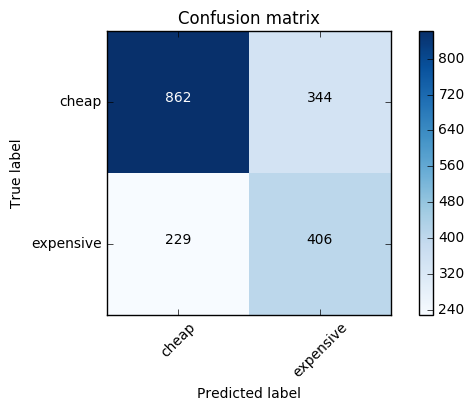

In [29]:
print "Variant 1: NB_Numeric"
nb_numeric = GaussianNB()
nb_numeric.fit(X=df[numeric_columns], y=df['price'])

pred = nb_numeric.predict(X=df[numeric_columns])
print "\n Accuracy on training set: ", accuracy_score(df['price'], pred)
print "\n Confusion matix on training set:\n", confusion_matrix(df['price'], pred)

# Randomly shuffling the records of the original data
df_new = df.reindex(np.random.permutation(df.index))
X = df_new[numeric_columns]
y_true = df_new['price']

# 10-Fold CV
nb_numeric = GaussianNB()
n_folds = 10
scores = cross_val_score(nb_numeric, X=X, y=y_true, cv=n_folds) 
print "\n Accuracy scores from the 10 folds:\n", scores
print "\n Average accuracy from 10-fold CV:", scores.mean()

nb_numeric = GaussianNB()
nb_numeric.fit(X=X_train[numeric_columns], y=y_train)
pred = nb_numeric.predict(X=X_test[numeric_columns])

print "\n Accuracy on test set: ", accuracy_score(y_test, pred)
print "\n Confusion matix on training set:"
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=['cheap', 'expensive'])


#### Variant 2: NB_Categorical

Variant 2: NB_Categorical

 Accuracy on training set:  0.718213431863

 Confusion matix on training set:
[[4907 1117]
 [1476 1702]]

 Accuracy scores from the 10 folds:
[ 0.73072747  0.7111835   0.72964169  0.71986971  0.6923913   0.71630435
  0.70543478  0.73152174  0.73340588  0.70293798]

 Average accuracy from 10-fold CV: 0.717341839292

 Accuracy on test set:  0.721347093971

 Confusion matix on training set:
[[1002  204]
 [ 309  326]]


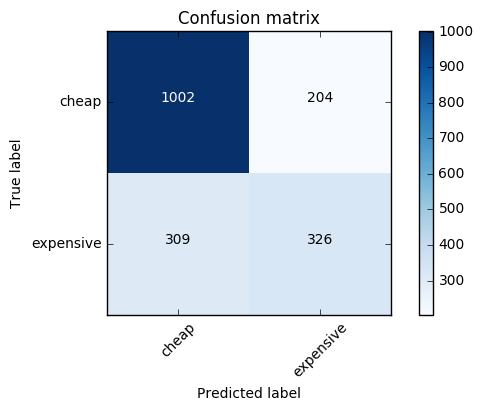

In [30]:
print "Variant 2: NB_Categorical"
nb_categorical = MultinomialNB()
nb_categorical.fit(X=df[categorical_columns], y=df['price'])

pred = nb_categorical.predict(X=df[categorical_columns])
print "\n Accuracy on training set: ", accuracy_score(df['price'], pred)
print "\n Confusion matix on training set:\n", confusion_matrix(df['price'], pred)

# Randomly shuffling the records of the original data
df_new = df.reindex(np.random.permutation(df.index))
X = df_new[categorical_columns]
y_true = df_new['price']

# 10-Fold CV
nb_numeric = MultinomialNB()
n_folds = 10
scores = cross_val_score(nb_categorical, X=X, y=y_true, cv=n_folds) 
print "\n Accuracy scores from the 10 folds:\n", scores
print "\n Average accuracy from 10-fold CV:", scores.mean()

nb_categorical = MultinomialNB()
nb_categorical.fit(X=X_train[categorical_columns], y=y_train)
pred = nb_categorical.predict(X=X_test[categorical_columns])

print "\n Accuracy on test set: ", accuracy_score(y_test, pred)
print "\n Confusion matix on training set:"
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=['cheap', 'expensive'])


#### Variant 3: NB_Numeric_Binned

In [31]:
# Binning numeric variables
# 3 equal bins by quartile cuts
# 1-low, 2-medium, 3-high
pd.Series(pd.qcut(df['atm'].rank(method='first').values, 3).codes + 1).value_counts() 

1    3068
3    3067
2    3067
dtype: int64

In [32]:
df_new = df
for col in numeric_columns:
    df_new[col] = pd.qcut(df[col].rank(method='first').values, 3).codes + 1    

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_new.ix[:,1:], df_new['price'], test_size=0.2, random_state=13)

Variant 3: NB_Numeric_Binned

 Accuracy on training set:  0.715387959139

 Confusion matix on training set:
[[4682 1342]
 [1277 1901]]

 Accuracy scores from the 10 folds:
[ 0.73615635  0.70901194  0.69815418  0.71335505  0.73043478  0.72826087
  0.7173913   0.69565217  0.71273123  0.71055495]

 Average accuracy from 10-fold CV: 0.71517028355

 Accuracy on test set:  0.724606192287

 Confusion matix on training set:
[[969 266]
 [241 365]]


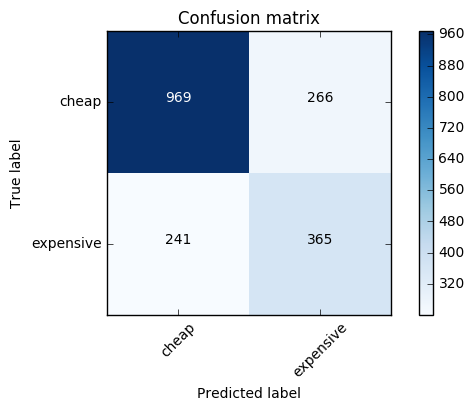

In [34]:
print "Variant 3: NB_Numeric_Binned"
nb_numeric_binned = MultinomialNB()
nb_numeric_binned.fit(X=df_new.ix[:,1:], y=df_new['price'])

pred = nb_numeric_binned.predict(X=df_new.ix[:,1:])
print "\n Accuracy on training set: ", accuracy_score(df_new['price'], pred)
print "\n Confusion matix on training set:\n", confusion_matrix(df_new['price'], pred)

# Randomly shuffling the records of the original data
df_new = df_new.reindex(np.random.permutation(df_new.index))
X = df_new.ix[:,1:]
y_true = df_new['price']

# 10-Fold CV
nb_numeric_binned = MultinomialNB()
n_folds = 10
scores = cross_val_score(nb_numeric_binned, X=X, y=y_true, cv=n_folds) 
print "\n Accuracy scores from the 10 folds:\n", scores
print "\n Average accuracy from 10-fold CV:", scores.mean()

nb_numeric_binned = MultinomialNB()
nb_numeric_binned.fit(X=X_train, y=y_train)
pred = nb_numeric_binned.predict(X=X_test)

print "\n Accuracy on test set: ", accuracy_score(y_test, pred)
print "\n Confusion matix on training set:"
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=['cheap', 'expensive'])

#### Variant 4: NB_Categorical_Converted

Variant 4: NB_Categorical_Converted

 Accuracy on training set:  0.704846772441

 Confusion matix on training set:
[[4399 1625]
 [1091 2087]]

 Accuracy scores from the 10 folds:
[ 0.72964169  0.72529859  0.72204126  0.72747014  0.72826087  0.73043478
  0.72934783  0.73695652  0.70946681  0.7203482 ]

 Average accuracy from 10-fold CV: 0.725926669928

 Accuracy on test set:  0.712112982075

 Confusion matix on training set:
[[901 305]
 [225 410]]


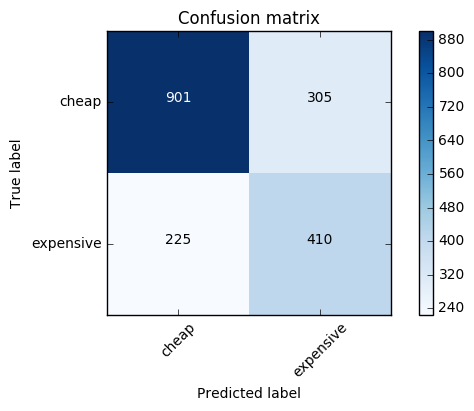

In [35]:
print "Variant 4: NB_Categorical_Converted"
# The predicted probabilities of the Multinomial NB on the categorial variables is added as a feature
nb_categorical = MultinomialNB()
nb_categorical.fit(X=df[categorical_columns], y=df['price'])
df_new = df
df_new['mnb_prob'] = pd.DataFrame(nb_categorical.predict_proba(X=df[categorical_columns]))[0]

nb_categorical_converted = GaussianNB()
nb_categorical_converted.fit(X=df_new[numeric_columns+['mnb_prob']], y=df_new['price'])

pred = nb_categorical_converted.predict(X=df_new[numeric_columns+['mnb_prob']])
print "\n Accuracy on training set: ", accuracy_score(df_new['price'], pred)
print "\n Confusion matix on training set:\n", confusion_matrix(df_new['price'], pred)

X_train, X_test, y_train, y_test = train_test_split(df_new.ix[:,1:], df_new['price'], test_size=0.2, random_state=13)

# Randomly shuffling the records of the original data
df_new = df_new.reindex(np.random.permutation(df_new.index))
X = df_new[numeric_columns+['mnb_prob']]
y_true = df_new['price']

# 10-Fold CV
nb_categorical_converted = GaussianNB()
n_folds = 10
scores = cross_val_score(nb_numeric, X=X, y=y_true, cv=n_folds) 
print "\n Accuracy scores from the 10 folds:\n", scores
print "\n Average accuracy from 10-fold CV:", scores.mean()

nb_categorical_converted = GaussianNB()
nb_categorical_converted.fit(X=X_train[numeric_columns+['mnb_prob']], y=y_train)
pred = nb_categorical_converted.predict(X=X_test[numeric_columns+['mnb_prob']])

print "\n Accuracy on test set: ", accuracy_score(y_test, pred)
print "\n Confusion matix on training set:"
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=['cheap', 'expensive'])

#### Variant 5: NB_Numeric_Converted

Variant 5: NB_Numeric_Converted

 Accuracy on training set:  0.696153010215

 Confusion matix on training set:
[[4555 1469]
 [1327 1851]]

 Accuracy scores from the 10 folds:
[ 0.70141151  0.66558089  0.7111835   0.67643865  0.70326087  0.68152174
  0.71956522  0.69891304  0.71164309  0.68008705]

 Average accuracy from 10-fold CV: 0.694960556043

 Accuracy on test set:  0.738185768604

 Confusion matix on training set:
[[1005  230]
 [ 252  354]]


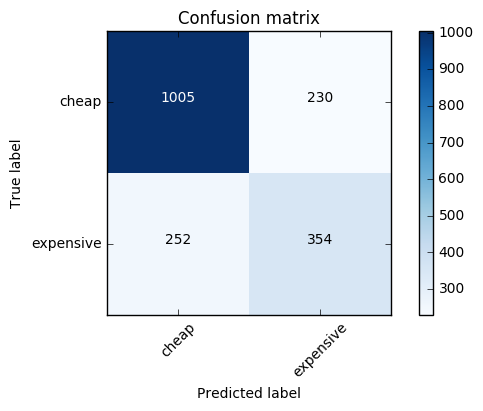

In [43]:
print "Variant 5: NB_Numeric_Converted"
# The predicted class labels of the Gaussian NB on the numeric variables is added as a feature
nb_numeric = GaussianNB()
nb_numeric.fit(X=df[numeric_columns], y=df['price'])
df_new = df
df_new['gaussian_label'] = pd.DataFrame(nb_numeric.predict(X=df[numeric_columns]))[0]

nb_numeric_converted = MultinomialNB()
nb_numeric_converted.fit(X=df_new[numeric_columns+['gaussian_label']], y=df_new['price'])

pred = nb_numeric_converted.predict(X=df_new[numeric_columns+['gaussian_label']])
print "\n Accuracy on training set: ", accuracy_score(df_new['price'], pred)
print "\n Confusion matix on training set:\n", confusion_matrix(df_new['price'], pred)

X_train, X_test, y_train, y_test = train_test_split(df_new.ix[:,1:], df_new['price'], test_size=0.2, random_state=13)

# Randomly shuffling the records of the original data
df_new = df_new.reindex(np.random.permutation(df_new.index))
X = df_new[categorical_columns+['gaussian_label']]
y_true = df_new['price']

# 10-Fold CV
nb_numeric_converted = MultinomialNB()
n_folds = 10
scores = cross_val_score(nb_numeric, X=X, y=y_true, cv=n_folds) 
print "\n Accuracy scores from the 10 folds:\n", scores
print "\n Average accuracy from 10-fold CV:", scores.mean()

nb_numeric_converted = MultinomialNB()
nb_numeric_converted.fit(X=X_train[categorical_columns+['gaussian_label']], y=y_train)
pred = nb_numeric_converted.predict(X=X_test[categorical_columns+['gaussian_label']])

print "\n Accuracy on test set: ", accuracy_score(y_test, pred)
print "\n Confusion matix on training set:"
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=['cheap', 'expensive'])



#### Variant 6: NB_Combined

Variant 6: NB_Combined

 Accuracy on training set:  0.731688763312

 Confusion matix on training set:
[[4874 1150]
 [1319 1859]]

 Accuracy scores from the 10 folds:
[ 0.72638436  0.72855592  0.72529859  0.72204126  0.71956522  0.74456522
  0.73913043  0.74130435  0.73558215  0.72796518]

 Average accuracy from 10-fold CV: 0.731039268174

 Accuracy on test set:  0.74144486692

 Confusion matix on training set:
[[1005  230]
 [ 246  360]]


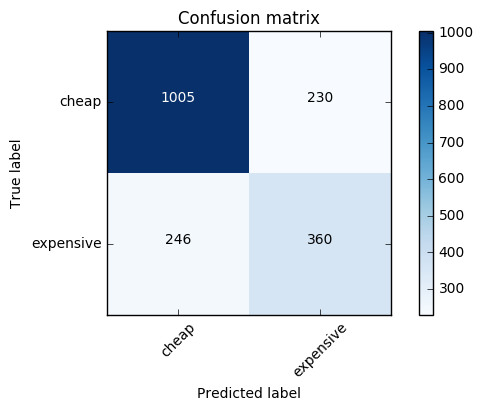

In [42]:
print "Variant 6: NB_Combined"
# The predicted probabilities from Gaussian NB and Multinomial NB fed into a new Gaussian NB
nb_numeric = GaussianNB()
nb_numeric.fit(X=df[numeric_columns], y=df['price'])
df_new = df
df_new['gaussian_prob'] = pd.DataFrame(nb_numeric.predict_proba(X=df[numeric_columns]))[0]

nb_categorical = MultinomialNB()
nb_categorical.fit(X=df[categorical_columns], y=df['price'])
df_new = df
df_new['mnb_prob'] = pd.DataFrame(nb_categorical.predict_proba(X=df[categorical_columns]))[0]

nb_combined = GaussianNB()
nb_combined.fit(X=df_new[['mnb_prob', 'gaussian_prob']], y=df_new['price'])

pred = nb_combined.predict(X=df_new[['mnb_prob', 'gaussian_prob']])
print "\n Accuracy on training set: ", accuracy_score(df_new['price'], pred)
print "\n Confusion matix on training set:\n", confusion_matrix(df_new['price'], pred)

X_train, X_test, y_train, y_test = train_test_split(df_new.ix[:,1:], df_new['price'], test_size=0.2, random_state=13)

# Randomly shuffling the records of the original data
df_new = df_new.reindex(np.random.permutation(df_new.index))
X = df_new[['mnb_prob', 'gaussian_prob']]
y_true = df_new['price']

# 10-Fold CV
nb_combined = GaussianNB()
n_folds = 10
scores = cross_val_score(nb_combined, X=X, y=y_true, cv=n_folds) 
print "\n Accuracy scores from the 10 folds:\n", scores
print "\n Average accuracy from 10-fold CV:", scores.mean()

nb_combined = GaussianNB()
nb_combined.fit(X=X_train[['mnb_prob', 'gaussian_prob']], y=y_train)
pred = nb_combined.predict(X=X_test[['mnb_prob', 'gaussian_prob']])

print "\n Accuracy on test set: ", accuracy_score(y_test, pred)
print "\n Confusion matix on training set:"
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=['cheap', 'expensive'])